In [1]:
import jax.numpy as jnp
import jax
import numpy as np

%config InlineBackend.figure_format = "retina"
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

In [2]:
pauli_x = [[0., 1.], [1., 0.]]
pauli_y = [[0., -1.j], [1.j, 0.]]
pauli_z = [[1., 0.], [0., -1.]]

pauli = jnp.asarray([pauli_x, pauli_y, pauli_z])

basis = jnp.asarray([
    [[1, 0], [0, 0]],
    [[0, 1], [0, 0]],
    [[0, 0], [1, 0]],
    [[0, 0], [0, 1]],
])

In [3]:
def matrix2coords(matrix, basis):
    return jnp.einsum('ij, aji -> a', matrix, basis)

def coords2matrix(coords, basis):
    return jnp.einsum('a, aij -> ij', coords, basis)

In [4]:
def gram_matrix(operator, mu, nu):
    mapx1 = jax.vmap(lambda mu, nu: operator(mu, nu), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda mu, nu: mapx1(mu, nu), in_axes=(None, 0), out_axes=1)
    return mapx2(mu, nu)


def lindbladian_coords(hamiltonian, kraus, basis):
    
    def lindbladian(mu, nu):
        Lt = -1.j*(hamiltonian @ nu - nu @ hamiltonian)
        for k in kraus:
            Lt += k @ (nu @ jnp.conjugate(k.T)) - 0.5*((jnp.conjugate(k.T)@k)@nu + (jnp.conjugate(k.T)@k)@nu)
        return jnp.trace(mu.T @ Lt)
    
    return gram_matrix(lindbladian, basis, basis)


In [107]:
# Determininstic evolution
omega0 = 1.
hamiltonian0 = omega0*pauli[2]

# Noisy evolution
gamma = 0.1
#theta, phi = 0., 0.
#n = jnp.asarray([jnp.cos(phi)*jnp.sin(theta), jnp.sin(phi)*jnp.sin(theta), jnp.cos(theta)])
n = jnp.asarray([1, 1, 1])
kraus = jnp.sqrt(gamma) * jnp.einsum('a, aij -> aij', n, pauli)

# Initial conditions
s = jnp.asarray([1,1,1])/jnp.sqrt(3)
rho0 = 0.5 * (jnp.eye(2) + jnp.einsum('a, aij -> ij', s, pauli))
rho0_coords = matrix2coords(rho0, basis)

# Set-up simulation
times = jnp.linspace(0, 1/(2*gamma), 1001)
rhos0 = [rho0_coords]
D_rhos0 = [jnp.zeros((4))]
information0 = [0]

# Run simulation
for idx in range(1, len(times)):
    rho0_last = rhos0[idx-1]

    t = times[idx]
    dt = times[idx] - times[idx-1]

    # Time evolution
    field_ = 0.5*jnp.asarray([jnp.cos(1*t), jnp.cos(0.1*t), 1-jnp.exp(-0.1*t)]) # Protocol
    hamiltonian_control = jnp.einsum('a, aij -> ij', field_, pauli) 
    hamiltonian0_ = hamiltonian0 + hamiltonian_control
    lindbladian0 = lindbladian_coords(hamiltonian0_, kraus, basis)
    v, d, vh = jnp.linalg.svd(lindbladian0, full_matrices=True, compute_uv=True, hermitian=False)
    rho0_next = jax.scipy.linalg.expm(lindbladian0 * dt) @ rho0_last
    rhos0.append(rho0_next)    

    # Derivative of the density rho
    lindbladian_a = lindbladian_coords(pauli[2], [], basis)
    lindbladian_a_conjugated = vh @ lindbladian_a @ v
    A = jnp.zeros(lindbladian_a.shape)
    for i in range(lindbladian_a.shape[0]):
        for j in range(lindbladian_a.shape[1]):
            wiggle = 1e-8
            #TODO Implement this
            # x = (jnp.exp(dt * d[i]) - jnp.exp(dt * d[j])) / (d[i] - d[j] + wiggle)
            #A = A.at[i,j].set(x * lindbladian_a_conjugated[i,j])/dt
            A = A.at[i,j].set(lindbladian_a_conjugated[i,j] * (1 + 0.5*dt*(d[i]+d[j])) * dt)

    D_propogator = v @ A @ vh
    D_rho0_last = D_rhos0[idx-1]
    D_rho0_next = D_propogator @ rho0_last + jax.scipy.linalg.expm(lindbladian0 * dt) @ D_rho0_last
    D_rhos0.append(D_rho0_next)

    # Quantum Fisher Information
    u, s, uh = jnp.linalg.svd(coords2matrix(rho0_last, basis), full_matrices=True, compute_uv=True, hermitian=True)
    D = uh @ coords2matrix(D_rho0_last, basis) @ u
    F = jnp.zeros(D.shape)
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            wiggle = 1e-8
            x = (4*s[i]) / ((s[i] + s[j])**2 + wiggle)
            y = jnp.abs(D[i,j])**2
            F = F.at[i,j].set(x * y)
            # Fix there is an extra factor of 4 (maybe?)
    
    information_next = jnp.sum(F)
    information0.append(information_next)
    
    


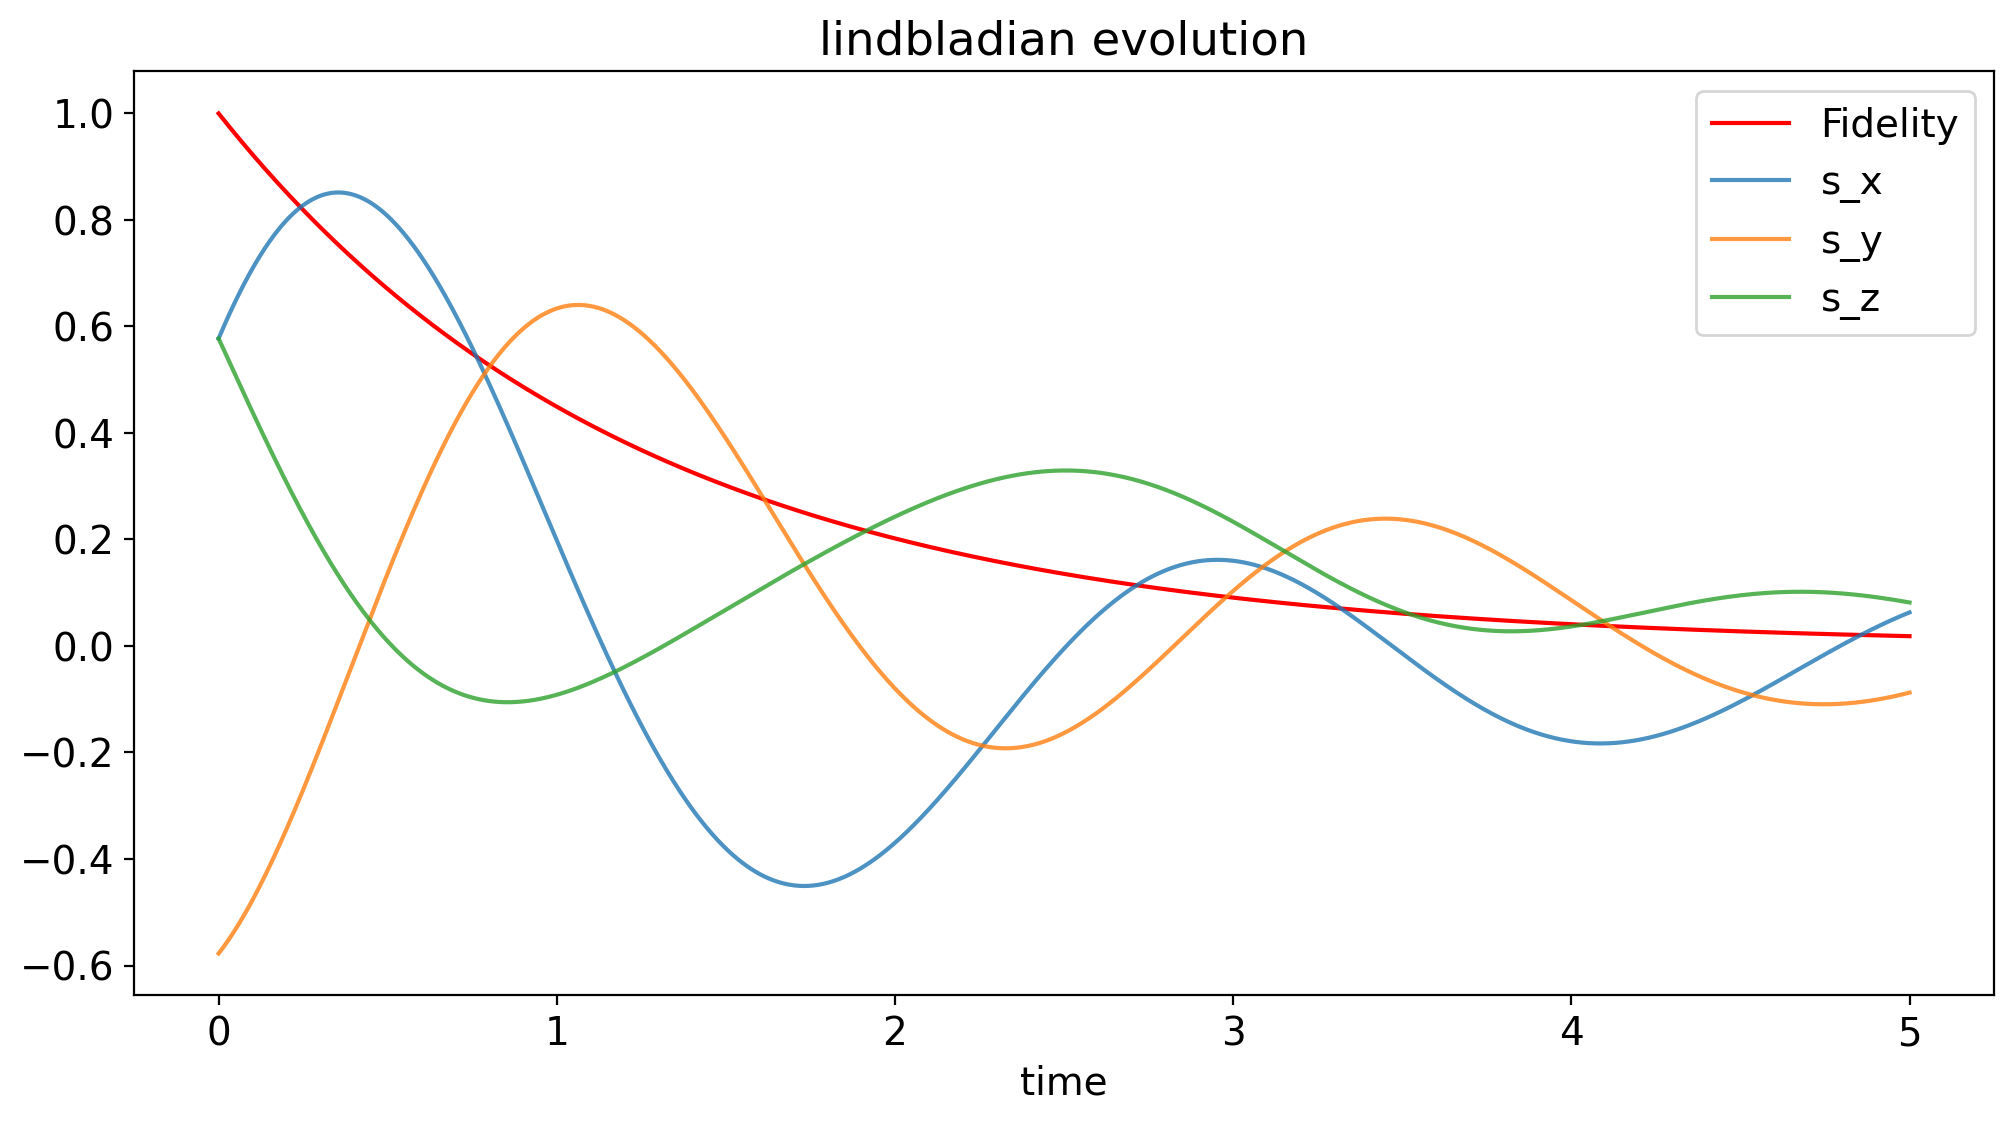

In [108]:
# Plot the state evolution
rhos = [coords2matrix(x, basis) for x in rhos0]
purity = [jnp.trace(x @ jnp.conjugate(x.T)) for x in rhos]

bloch_sphere = [jnp.einsum('aij, ji -> a', pauli, rho) for rho in rhos]

# Plot data
plt.figure(figsize=(12,6))
plt.plot(times, 2*jnp.asarray(purity) - 1, color="r", alpha=1, label='Fidelity', zorder=1)


plt.plot(times, jnp.real(jnp.asarray(bloch_sphere)[:,0]), alpha=0.8, label='s_x', zorder=1)
plt.plot(times, jnp.real(jnp.asarray(bloch_sphere)[:,1]), alpha=0.8, label='s_y', zorder=1)
plt.plot(times, jnp.real(jnp.asarray(bloch_sphere)[:,2]), alpha=0.8, label='s_z', zorder=1)

plt.xlabel('time')
plt.title('lindbladian evolution')
plt.legend()
plt.show()

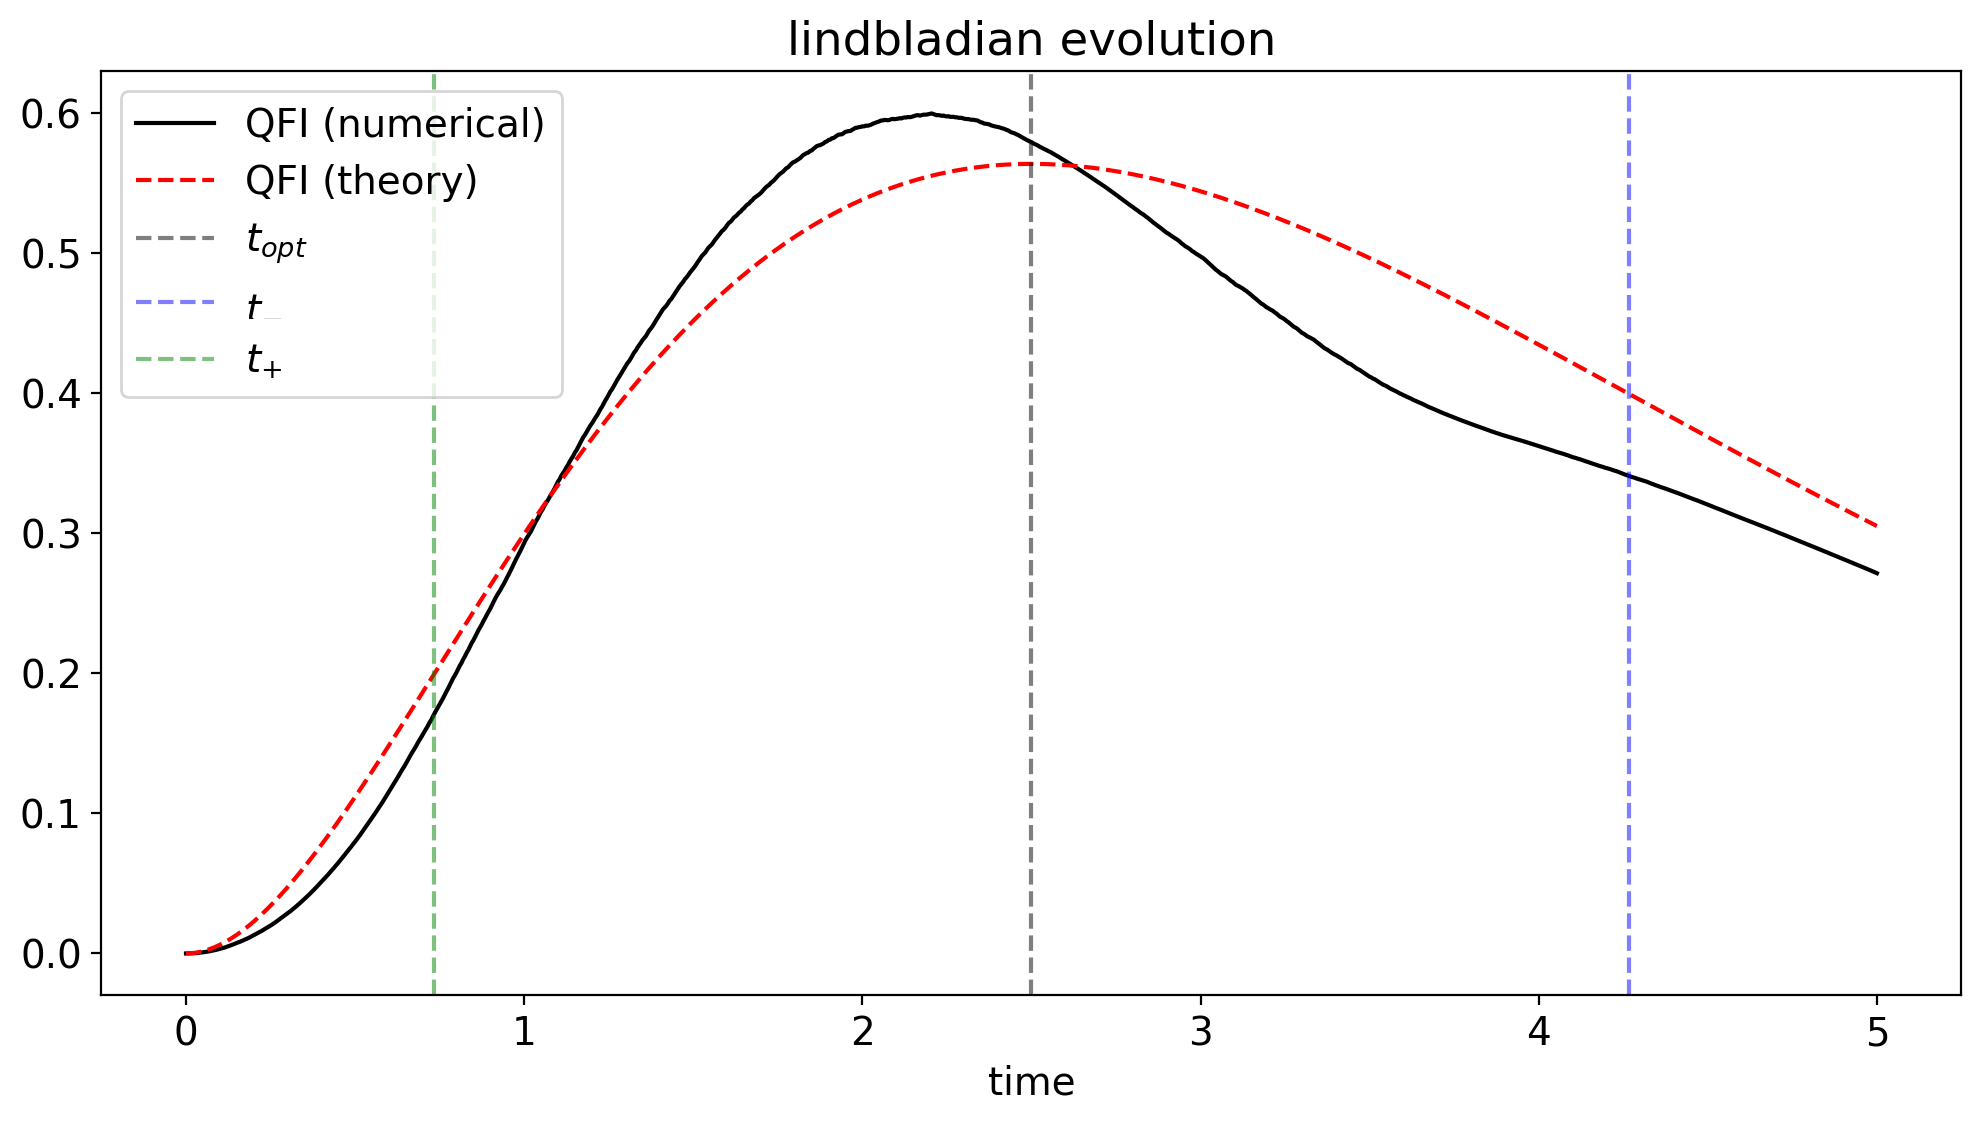

In [119]:
# Plot data
plt.figure(figsize=(12,6))
plt.plot(times, jnp.asarray(information0)/4, color="black", alpha=1, label='QFI (numerical)', zorder=1)

#Theoretical values
information_theoretical = 4*jnp.abs(rho0[0,1])**2 * times**2 * jnp.exp(-8*gamma*times)
plt.plot(times, information_theoretical, color="red", linestyle='dashed', alpha=1, label='QFI (theory)', zorder=1)

information_max = jnp.max(information_theoretical)
information0_max, t_opt0 = jnp.max(jnp.asarray(information0))/4, times[jnp.argmax(jnp.asarray(information0))]

#calculate important times
t_opt = 1/(4*gamma)
t_minus = (2+jnp.sqrt(2))/(8*gamma)
t_plus = (2-jnp.sqrt(2))/(8*gamma)

plt.axvline(x=t_opt, color='black', linestyle='dashed', alpha=0.5, label='$t_{opt}$')
plt.axvline(x=t_minus, color='blue', linestyle='dashed', alpha=0.5, label='$t_{-}$')
plt.axvline(x=t_plus, color='green', linestyle='dashed', alpha=0.5, label='$t_{+}$')

plt.xlabel('time')
plt.title('lindbladian evolution')
plt.legend()
plt.show()

In [120]:
gain = (information0_max / information_max) * (t_opt / t_opt0)
print(gain)


1.2061831
